In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.transpiler import CouplingMap

from gate_level.spillover_noise_use_case.generic_spillover.generic_spillover_noise import (
    numpy_to_hashable,
)
from generic_spillover_noise import (
    circuit_context,
    noisy_backend,
    SpilloverNoiseAerPass,
)
from rl_qoc import (
    ContextAwareQuantumEnvironment,
    QiskitConfig,
    QEnvConfig,
    ExecutionConfig,
    GateTarget,
)
import matplotlib.pyplot as plt

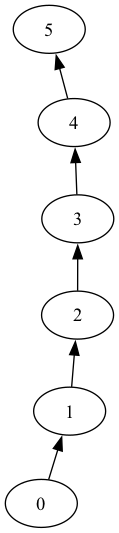

In [2]:
# Define the number of qubits
num_qubits = 6
cm = CouplingMap.from_line(num_qubits, False)
cm.draw()

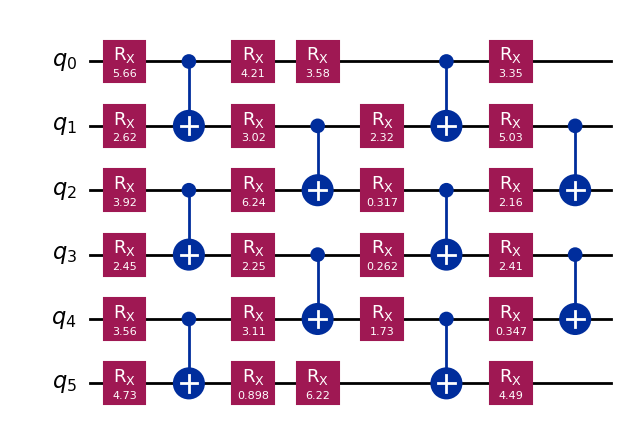

In [3]:
# Define parameters for U(phi) gates
# phi_rotation_values = np.pi * np.array([0.25, 0.5, 0.75, 1])
# phi_arr = np.random.choice(phi_rotation_values, size=num_qubits)
n_layers = 4
rotation_angles = np.random.uniform(0, 2 * np.pi, size=num_qubits * n_layers)
from qiskit.circuit.library import TwoLocal

qc = TwoLocal(
    num_qubits,
    "rx",
    "cx",
    entanglement=[[(0, 1), (2, 3), (4, 5)], [(1, 2), (3, 4)]],
    reps=n_layers,
    flatten=True,
    skip_unentangled_qubits=True,
    skip_final_rotation_layer=True,
)
qc = qc.assign_parameters(rotation_angles, inplace=False)
qc.draw("mpl")

In [4]:
print(qc.data)

[CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[5.658229627718949]), qubits=(Qubit(QuantumRegister(6, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[2.6170591391070936]), qubits=(Qubit(QuantumRegister(6, 'q'), 1),), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[3.9150659938110297]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[2.45228234222678]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[3.564000688157971]), qubits=(Qubit(QuantumRegister(6, 'q'), 4),), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[4.734939158846935]), qubits=(Qubit(QuantumRegister(6, 'q'), 5),), clbits=()), Ci

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.025  # γ_0->1
gamma_matrix[0, 3] = 0.025  # γ_0->3
gamma_matrix[1, 2] = 0.025  # γ_1->2
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 2] = 0.025  # γ_3->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 4] = 0.025  # γ_5->4

gamma_matrix

array([[0.   , 0.025, 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.025, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.025, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.025, 0.   ]])

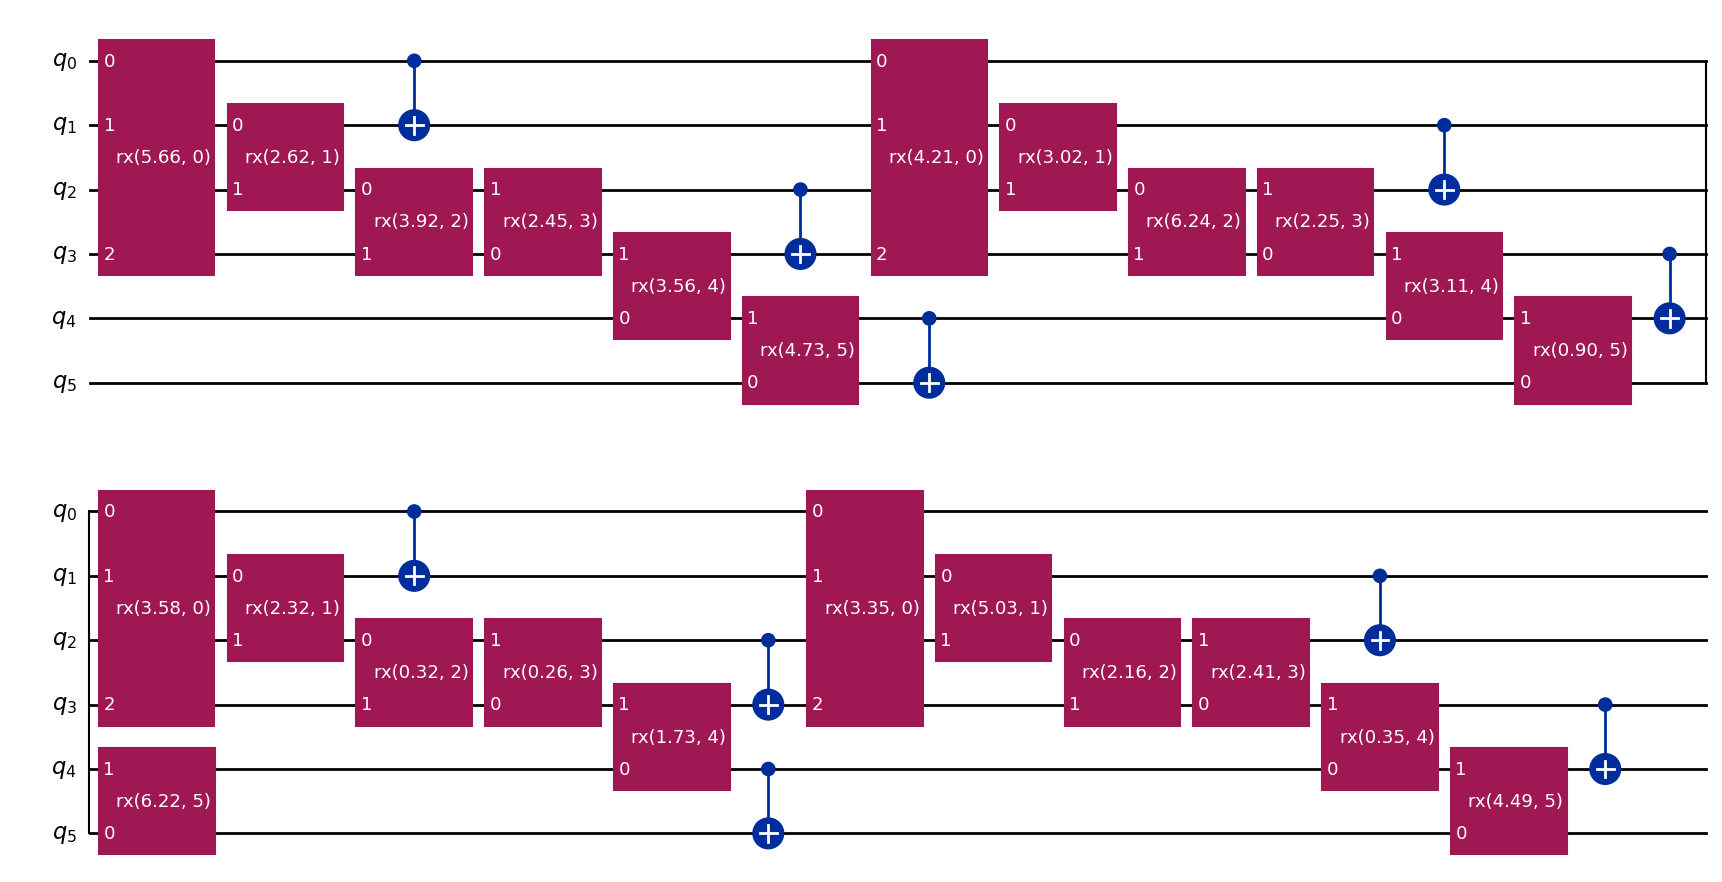

In [6]:
from qiskit.transpiler import PassManager

pm = PassManager(
    [SpilloverNoiseAerPass(spillover_rate_matrix=numpy_to_hashable(gamma_matrix))]
)
noisy_qc = pm.run(qc)
noisy_qc.draw("mpl")

In [7]:
# Create the noisy backend tailored for spillover noise
backend = noisy_backend(qc, gamma_matrix, coupling_map=cm)
backend

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['rx(0.32, 2)', 'rx(2.25, 3)', 'rx(0.90, 5)', 'rx(2.41, 3)', 'rx(4.49, 5)', 'rx(5.03, 1)', 'rx(3.11, 4)', 'rx(3.58, 0)', 'rx(6.22, 5)', 'rx(2.16, 2)', 'rx(5.66, 0)', 'rx(2.62, 1)', 'rx(3.56, 4)', 'rx(4.73, 5)', 'rx(3.92, 2)', 'rx(0.35, 4)', 'rx(0.26, 3)', 'rx(3.02, 1)', 'rx(1.73, 4)', 'rx(3.35, 0)', 'rx(2.45, 3)', 'rx(2.32, 1)', 'rx(4.21, 0)', 'rx(6.24, 2)']>)

In [8]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '9a2f7b656e4846ab86edfd9481ddb58b',
   'operations': ['rx(5.66, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1, 2],
      'params': [array([[ 0.9950059+0.j        ,  0.       +0.j        ,
                0.       -0.07049223j,  0.       +0.j        ,
                0.       -0.07049223j,  0.       +0.j        ,
               -0.0049941-0.j        ,  0.       +0.j        ],
              [ 0.       +0.j        ,  0.9950059+0.j        ,
                0.       +0.j        ,  0.       -0.07049223j,
                0.       +0.j        ,  0.       -0.07049223j,
                0.       +0.j        , -0.0049941-0.j        ],
              [ 0.       -0.07049223j,  0.       +0.j        ,
                0.9950059+0.j        ,  0.       +0.j        ,
               -0.0049941-0.j        ,  0.       +0.j        ,
                0.       -0.07049223j,  0.       +0.j        ],
              [ 0.       +0.j        ,  0.       -0.0

In [9]:
from qiskit import QuantumRegister
from rl_qoc.helpers import get_gate

# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))

    my_qc.u(
        optimal_params[0] + params[0],
        optimal_params[1] + params[1],
        optimal_params[2] + params[2],
        q_reg[0],
    )
    my_qc.u(
        optimal_params[3] + params[3],
        optimal_params[4] + params[4],
        optimal_params[5] + params[5],
        q_reg[1],
    )

    my_qc.rzx(optimal_params[6] + params[6], q_reg[0], q_reg[1])
    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [10]:
# Define the environment
from gymnasium.spaces import Box
from qiskit.circuit.library import CXGate
from gymnasium.wrappers import RescaleAction, ClipAction

action_space = Box(low=-0.2, high=0.2, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    pass_manager=pm,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=64,
        n_reps=1,
        n_shots=50,
        sampling_paulis=100,
    ),
    reward_config="channel",
)
q_env = ContextAwareQuantumEnvironment(q_env_config, circuit_context=qc)
rescaled_env = ClipAction(q_env)

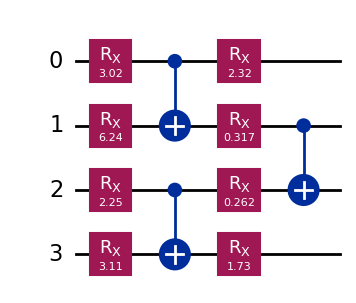

In [16]:
q_env._target[1].causal_cone_circuit.draw("mpl")

In [17]:
backend.operations

[qiskit.quantum_info.operators.channel.quantum_channel.QuantumChannel,
 qiskit.circuit.controlflow.if_else.IfElseOp,
 qiskit_aer.library.save_instructions.save_statevector.SaveStatevectorDict,
 qiskit_aer.library.set_instructions.set_unitary.SetUnitary,
 qiskit_aer.library.save_instructions.save_matrix_product_state.SaveMatrixProductState,
 qiskit.circuit.controlflow.for_loop.ForLoopOp,
 qiskit.quantum_info.operators.channel.superop.SuperOp,
 Instruction(name='ry', num_qubits=1, num_clbits=0, params=[Parameter(ϴ)]),
 qiskit.circuit.controlflow.continue_loop.ContinueLoopOp,
 qiskit_aer.library.set_instructions.set_density_matrix.SetDensityMatrix,
 qiskit_aer.library.save_instructions.save_density_matrix.SaveDensityMatrix,
 qiskit_aer.library.save_instructions.save_superop.SaveSuperOp,
 qiskit_aer.library.save_instructions.save_probabilities.SaveProbabilities,
 Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 qiskit_aer.noise.noise_model.QuantumErrorLocation,
 Instruc

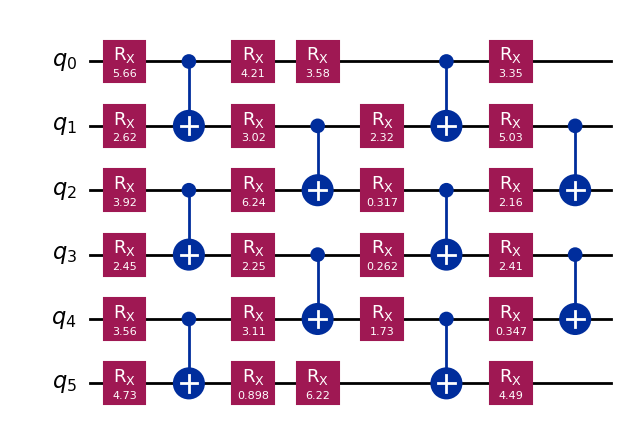

In [18]:
q_env.circuit_context.draw("mpl")

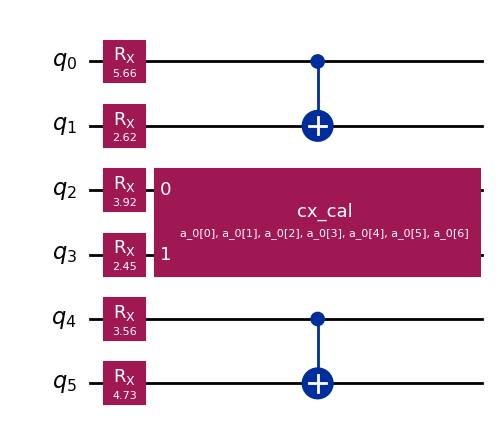

In [19]:
q_env.circuits[0].draw("mpl")

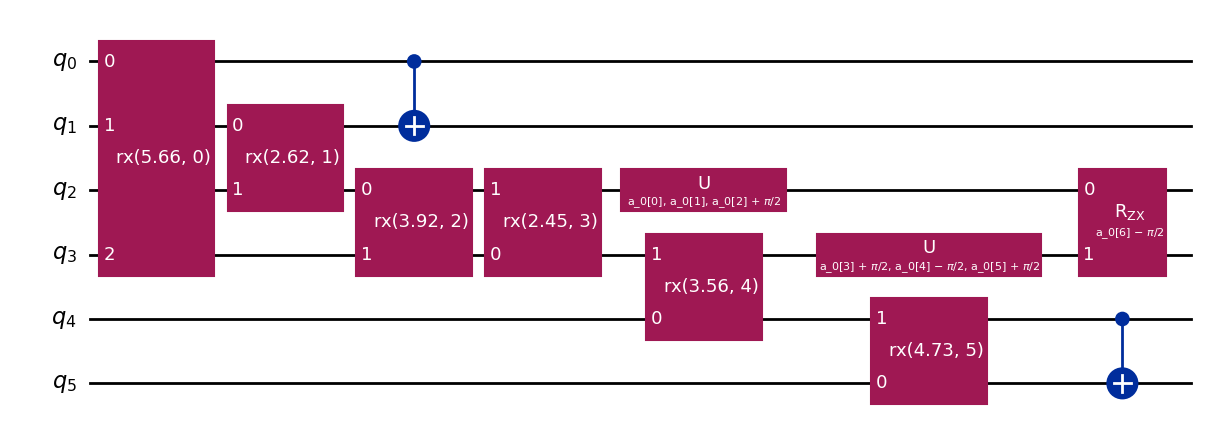

In [20]:
q_env.backend_info.custom_transpile(q_env.circuits[0]).draw("mpl")

In [21]:
from rl_qoc.helpers import load_from_yaml_file
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = file_name

agent_config = load_from_yaml_file(file_location)

In [16]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env)
total_updates = 500
target_fidelities = [0.9]
lookback_window = 20
anneal_learning_rate = False

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

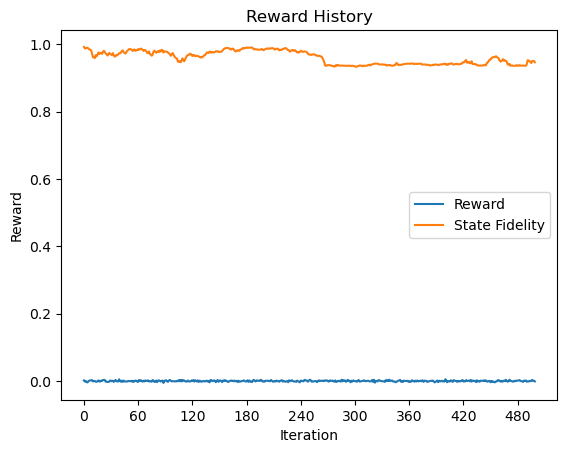

100%|██████████| 500/500 [16:14<00:00,  1.95s/it]

2024-11-22 12:37:25 INFO Target fidelity 0.9 achieved: Update 21, Hardware Runtime: 0.0 sec, Simulation Train Time: 0.6785 mins, Shots Used 2,219,584


{'env_ident_str': 'gate_calibration_cx-gate_physical_qubits_2-3',
 'reward_method': 'channel',
 'training_constraint': TotalUpdates(total_updates=500),
 'avg_reward': [0.0019188372710039823,
  -0.001546547848604487,
  -0.00010954706753584713,
  -0.003066750312184905,
  -0.004001525955763167,
  -0.0002331979163228798,
  0.00096130369315077,
  0.001997851432272428,
  0.002037532196667053,
  0.002749600309689489,
  -0.001063176064264427,
  -8.999747450097218e-05,
  0.00029620198252231606,
  -0.0022153150487266133,
  -0.0020151683278559467,
  -0.0008458983629800808,
  0.0020408748190621903,
  -0.0016866872015534884,
  -0.0010931560783059568,
  0.0013197833650095236,
  0.0004162280063177519,
  0.0025947338877298047,
  0.0035517099932881927,
  0.0031479665333614387,
  -0.0018097878317141392,
  -0.0013832802182687273,
  -0.002917311742361455,
  -0.0025254581532112258,
  -0.0019092581588853455,
  0.0017100373720351342,
  -0.0004650895193096501,
  0.0009720389165990709,
  4.465377761065574e-05,

<Figure size 640x480 with 0 Axes>

In [17]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

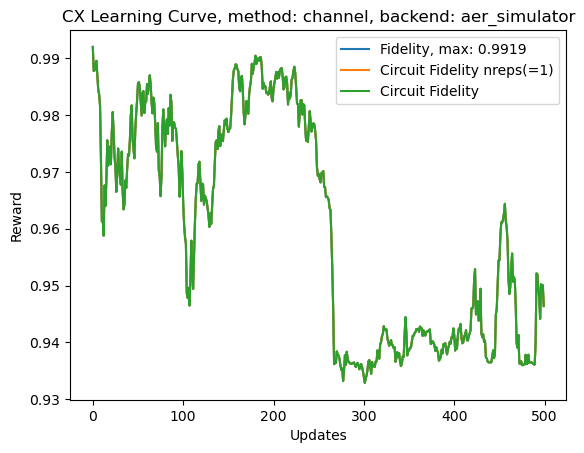

In [18]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

# plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(
    q_env.circuit_fidelity_history_nreps,
    label=f"Circuit Fidelity nreps(={q_env.n_reps})",
)
# plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

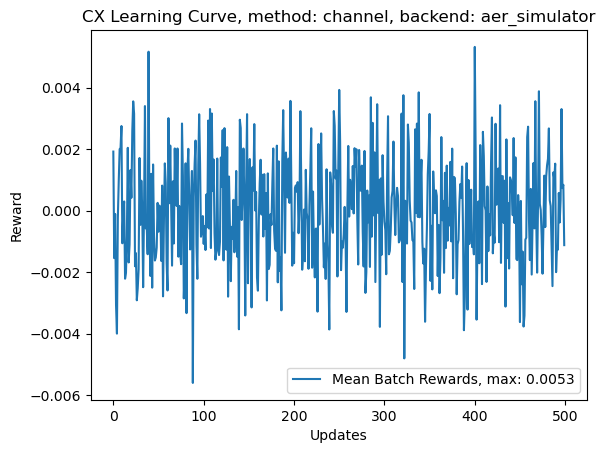

In [19]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
# plt.plot(
#     q_env.fidelity_history,
#     label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
# )
# plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
# plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
# plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [33]:
q_env.optimal_action

array([ 0.16718724, -0.1882672 , -0.16773811, -0.2       ,  0.02085974,
       -0.14108044,  0.2       ], dtype=float32)

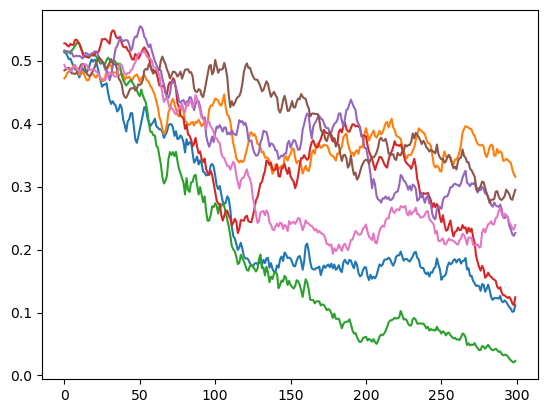

In [35]:
plt.plot(ppo_agent.training_results["std_action"])

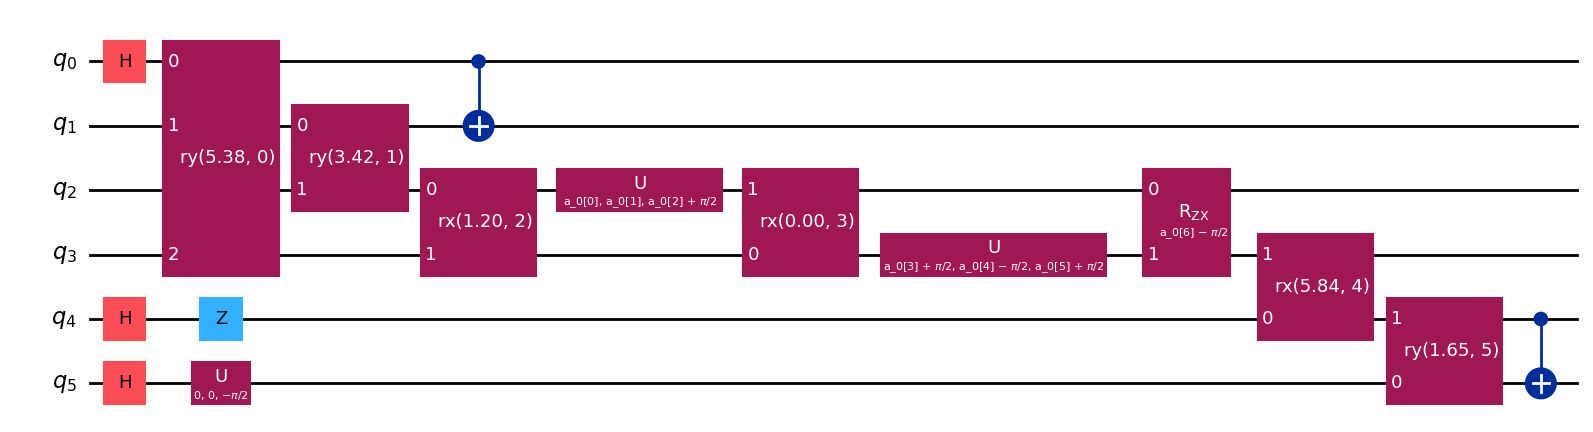

In [37]:
q_env._pubs[0][0].draw("mpl")